<img src="./Images/Hack.png" alt="HackaThon" height="1000" width="1000"/>



## *Test case* : _Currency Detector_


<img src="./Images/investing-in-robotics-1.jpg" alt="HackaThon" height="700" width="700"/>

# *Test case* : _Currency Detector_

In [1]:
#!pip install tensorflow
#!pip install pillow
#!pip install numpy
#!pip install opencv-python

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt


In [3]:
graph_def = tf.compat.v1.GraphDef()
labels = []

In [4]:
type(labels)

list

In [5]:
filename = "model.pb"
labels_filename = "labels.txt"

In [6]:
# Import the TF graph
with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [7]:
# Create a list of labels.
with open(labels_filename, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())

In [8]:
print(labels)

['10', '100', '20', '200', '2000', '50', '500']


In [9]:
from PIL import Image
import numpy as np
import cv2

In [10]:
# Load from a file
image = cv2.imread('test5.jpg')

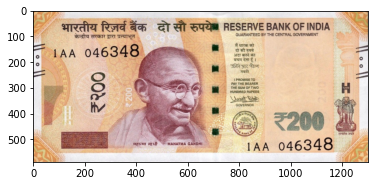

In [11]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [12]:
(h, w) = image.shape[:2]

In [13]:
(h, w)

(588, 1302)

In [14]:
def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

In [15]:
min_dim = min(w,h)
max_square_image = crop_center(image, min_dim, min_dim)

In [16]:
print(max_square_image)

[[[241 236 237]
  [240 235 236]
  [241 236 237]
  ...
  [241 236 237]
  [244 239 240]
  [243 238 239]]

 [[242 237 238]
  [242 237 238]
  [242 237 238]
  ...
  [240 235 236]
  [243 238 239]
  [242 237 238]]

 [[239 234 235]
  [239 234 235]
  [236 231 232]
  ...
  [239 234 235]
  [241 236 237]
  [242 237 238]]

 ...

 [[241 236 238]
  [245 240 242]
  [239 234 236]
  ...
  [231 226 227]
  [239 234 235]
  [234 229 230]]

 [[241 235 240]
  [245 239 244]
  [239 233 238]
  ...
  [232 227 228]
  [240 235 236]
  [235 230 231]]

 [[243 237 242]
  [247 241 246]
  [241 235 240]
  ...
  [236 231 232]
  [244 239 240]
  [238 233 234]]]


In [17]:
print(min_dim)

588


In [18]:
# Resize that square down to 256x256
augmented_image = resize_to_256_square(max_square_image)

In [19]:
print(augmented_image)

[[[241 236 237]
  [239 234 235]
  [238 233 234]
  ...
  [242 237 238]
  [240 235 236]
  [243 238 239]]

 [[237 232 233]
  [240 235 235]
  [236 231 232]
  ...
  [241 236 237]
  [237 232 233]
  [239 234 235]]

 [[239 234 235]
  [241 236 237]
  [239 234 235]
  ...
  [241 236 237]
  [236 230 231]
  [234 229 230]]

 ...

 [[235 232 234]
  [240 237 239]
  [238 235 237]
  ...
  [239 234 235]
  [232 228 228]
  [238 234 235]]

 [[244 239 241]
  [239 234 236]
  [240 235 237]
  ...
  [238 233 234]
  [241 236 237]
  [241 236 237]]

 [[244 238 243]
  [241 235 240]
  [243 237 242]
  ...
  [238 233 234]
  [241 236 237]
  [239 234 235]]]


In [20]:
# Get the input size of the model
with tf.compat.v1.Session() as sess:
    input_tensor_shape = sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
network_input_size = input_tensor_shape[1]

# Crop the center for the specified network_input_Size
augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

In [21]:
# These names are part of the model and cannot be changed.
output_layer = 'loss:0'
input_node = 'Placeholder:0'

with tf.compat.v1.Session() as sess:
    try:
        prob_tensor = sess.graph.get_tensor_by_name(output_layer)
        predictions = sess.run(prob_tensor, {input_node: [augmented_image] })
    except KeyError:
        print ("Couldn't find classification output layer: " + output_layer + ".")
        print ("Verify this a model exported from an Object Detection project.")
        exit(-1)

In [22]:
# Print the highest probability label
highest_probability_index = np.argmax(predictions)
print('This is ' + labels[highest_probability_index] + ' Rupee Note')
print(highest_probability_index)
print(predictions)


This is 200 Rupee Note
3
[[3.7959078e-03 1.4962378e-04 1.7086562e-04 7.6344746e-01 2.1133873e-01
  1.4714387e-04 2.0950288e-02]]


In [23]:
list1 = []

In [24]:
list1.append(labels[highest_probability_index])

In [25]:
list1

['200']

In [26]:
# Or you can print out all of the results mapping labels to probabilities.
label_index = 0
for p in predictions:
    truncated_probablity = np.float64(np.round(p,20))
    print (labels[label_index], truncated_probablity)
    label_index += 1

10 [3.79590783e-03 1.49623782e-04 1.70865620e-04 7.63447464e-01
 2.11338729e-01 1.47143874e-04 2.09502876e-02]


In [27]:
import speech_recognition as sr
from gtts import gTTS

In [28]:
str2 =''.join(list1)
str1 ='This is '
str3 = ' Rupees Note'

str = str1+str2+str3

In [29]:
str

'This is 200 Rupees Note'

In [30]:
language = 'en'

In [31]:
currency_output = gTTS(text=str, lang=language, slow=True)

In [32]:
currency_output.save("currency.mp3")

In [33]:
os.system('start currency.mp3')

0